In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
class SDESimulator:
    def __init__(self, x0, drift_coef, diff_coef, t_span, dt = 0.001):
        
        # grab dimensions
        self.x0 = np.array(x0)
        if self.x0.ndim == 1:
            self.x0 = self.x0.reshape(-1, 1)
        self.n_samples, self.dim = self.x0.shape

        self.drift_coef = drift_coef
        self.diff_coef = diff_coef
        self.t0, self.T  = t_span
        self.dt = dt

        self.t = np.arange(self.t0, self.T + dt, dt)
        self.n_steps = len(self.t)

    def simulate(self, n_traj = 1):
        x = np.zeros((n_traj, self.n_steps, self.dim))
        x[:, 0, :] = self.x0
        
        # forward sde
        for i in range(self.n_steps - 1):
            t = self.t[i]
            drift = self.drift_coef(x[:,i], t)
            diffusion = self.diff_coef(t)

            dw = np.sqrt(self.dt) * np.random.normal(0, 1, (n_traj, self.dim))
            x[:, i + 1] = x[:,i] + (drift * self.dt) + (diffusion * dw)

        return x
    
class ReverseSDESimulator:
    def __init__(self, drift_coef, diff_coef, score_fn, t_span, dt = 0.001, dim = None):

        self.drift_coef = drift_coef
        self.diff_coef = diff_coef
        self.score_fn = score_fn

        self.t0, self.T  = t_span
        self.dt = dt
        self.dim  = dim
        
        # reverse time grid
        self.t = np.flip(np.arange(self.t0, self.T + dt, dt))
        self.n_steps = len(self.t)


    def simulate(self, prior, mu, n_traj = 1):

        prior = np.array(prior)
        if prior.ndim == 1:
            prior = prior.reshape(-1, 1)
        
        x = np.zeros((n_traj, self.n_steps, prior.shape[1]))
        x[:, 0, :] = prior

        for i in range(self.n_steps - 1):
            t = self.t[i]
            drift = self.drift_coef(x[:,i, :], t)
            diffusion = self.diff_coef(t)
            score = self.score_fn(x[:,i, : ], mu, t)              

            #  brownian motion in reverse time
            dw_bar = np.sqrt(self.dt) * np.random.normal(0,1, (n_traj, prior.shape[1]))  
            reverse_drift = drift - (diffusion**2) * score
            dx = (reverse_drift * self.dt) + (diffusion *  dw_bar)

            x[:, i + 1] = x[:,i] + dx
        return x


In [22]:
# drift is set to zero
def drift(x, t):
    return 0
    
#Time-dependent diffusion coefficient - set to exp(t) follwing Song Y. article
def diffusion(t):
    return np.exp(t)

# score function - gradient log of p_t(x)
def score_fn(x, target_mean, t): 
    var_t = ((np.exp(2*t) - 1)/2) + 0.01
    return  (x - target_mean) / (var_t)

The setup for the sde is below:

mean = 20
variance = 0.1

In [23]:
# setup
t_span = (0,1)
n_samples = 1000


print(t_span)


# current state
mu = np.array([20])

# initial dist
#   x0 = np.repeat(mu, n_samples, axis = 0)
x0 = np.random.normal(mu, 0.1, (n_samples, len(mu)))

sde = SDESimulator(x0, drift, diffusion, t_span)
f_trajectories = sde.simulate(n_samples)
#print(f_trajectories[:, -1])


r_sde = ReverseSDESimulator(drift, diffusion, score_fn, t_span, dim = len(mu))
r_trajectories = r_sde.simulate(f_trajectories[:, -1], mu, n_samples)
#print(r_trajectories[:, 0])

(0, 1)


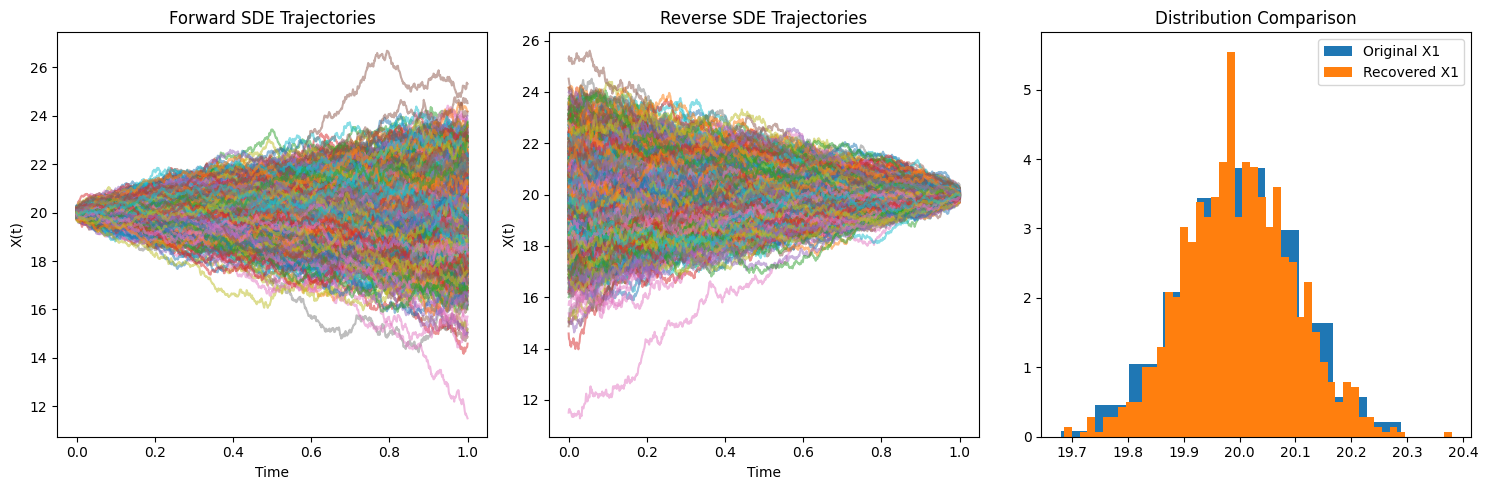

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
for i in range(n_samples):
    plt.plot(sde.t, f_trajectories[i, :, 0], alpha=0.5)
    #plt.plot(sde.t, f_trajectories[i, :, 1], alpha=0.5)
plt.title('Forward SDE Trajectories')
plt.xlabel('Time')
plt.ylabel('X(t)')

plt.subplot(132)
for i in range(n_samples):
    #print("\nreverse", i)
    #print(r_trajectories[i, :, 0])
    plt.plot(np.flip(r_sde.t), r_trajectories[i, :, 0], alpha=0.5)
    #plt.plot(r_sde.t, r_trajectories[i, :, 1], alpha=0.5)
plt.title('Reverse SDE Trajectories')
plt.xlabel('Time')
plt.ylabel('X(t)')


plt.subplot(133)
plt.hist(f_trajectories[:, 0], bins=10, alpha=1, label='Original X1', density=True)
plt.hist(r_trajectories[:, -1], bins=50, alpha=0.9, label='Recovered X1', density=True)
""" plt.hist(f_trajectories[:, 0, 1], bins=50, alpha=0.5, label='Original X2', density=True)
plt.hist(r_trajectories[:, -1, 1], bins=50, alpha=0.5, label='Recovered X2', density=True) """
plt.title('Distribution Comparison')
plt.legend()

plt.tight_layout()
plt.show()

[0, 200, 400, 600, 800, 1000]


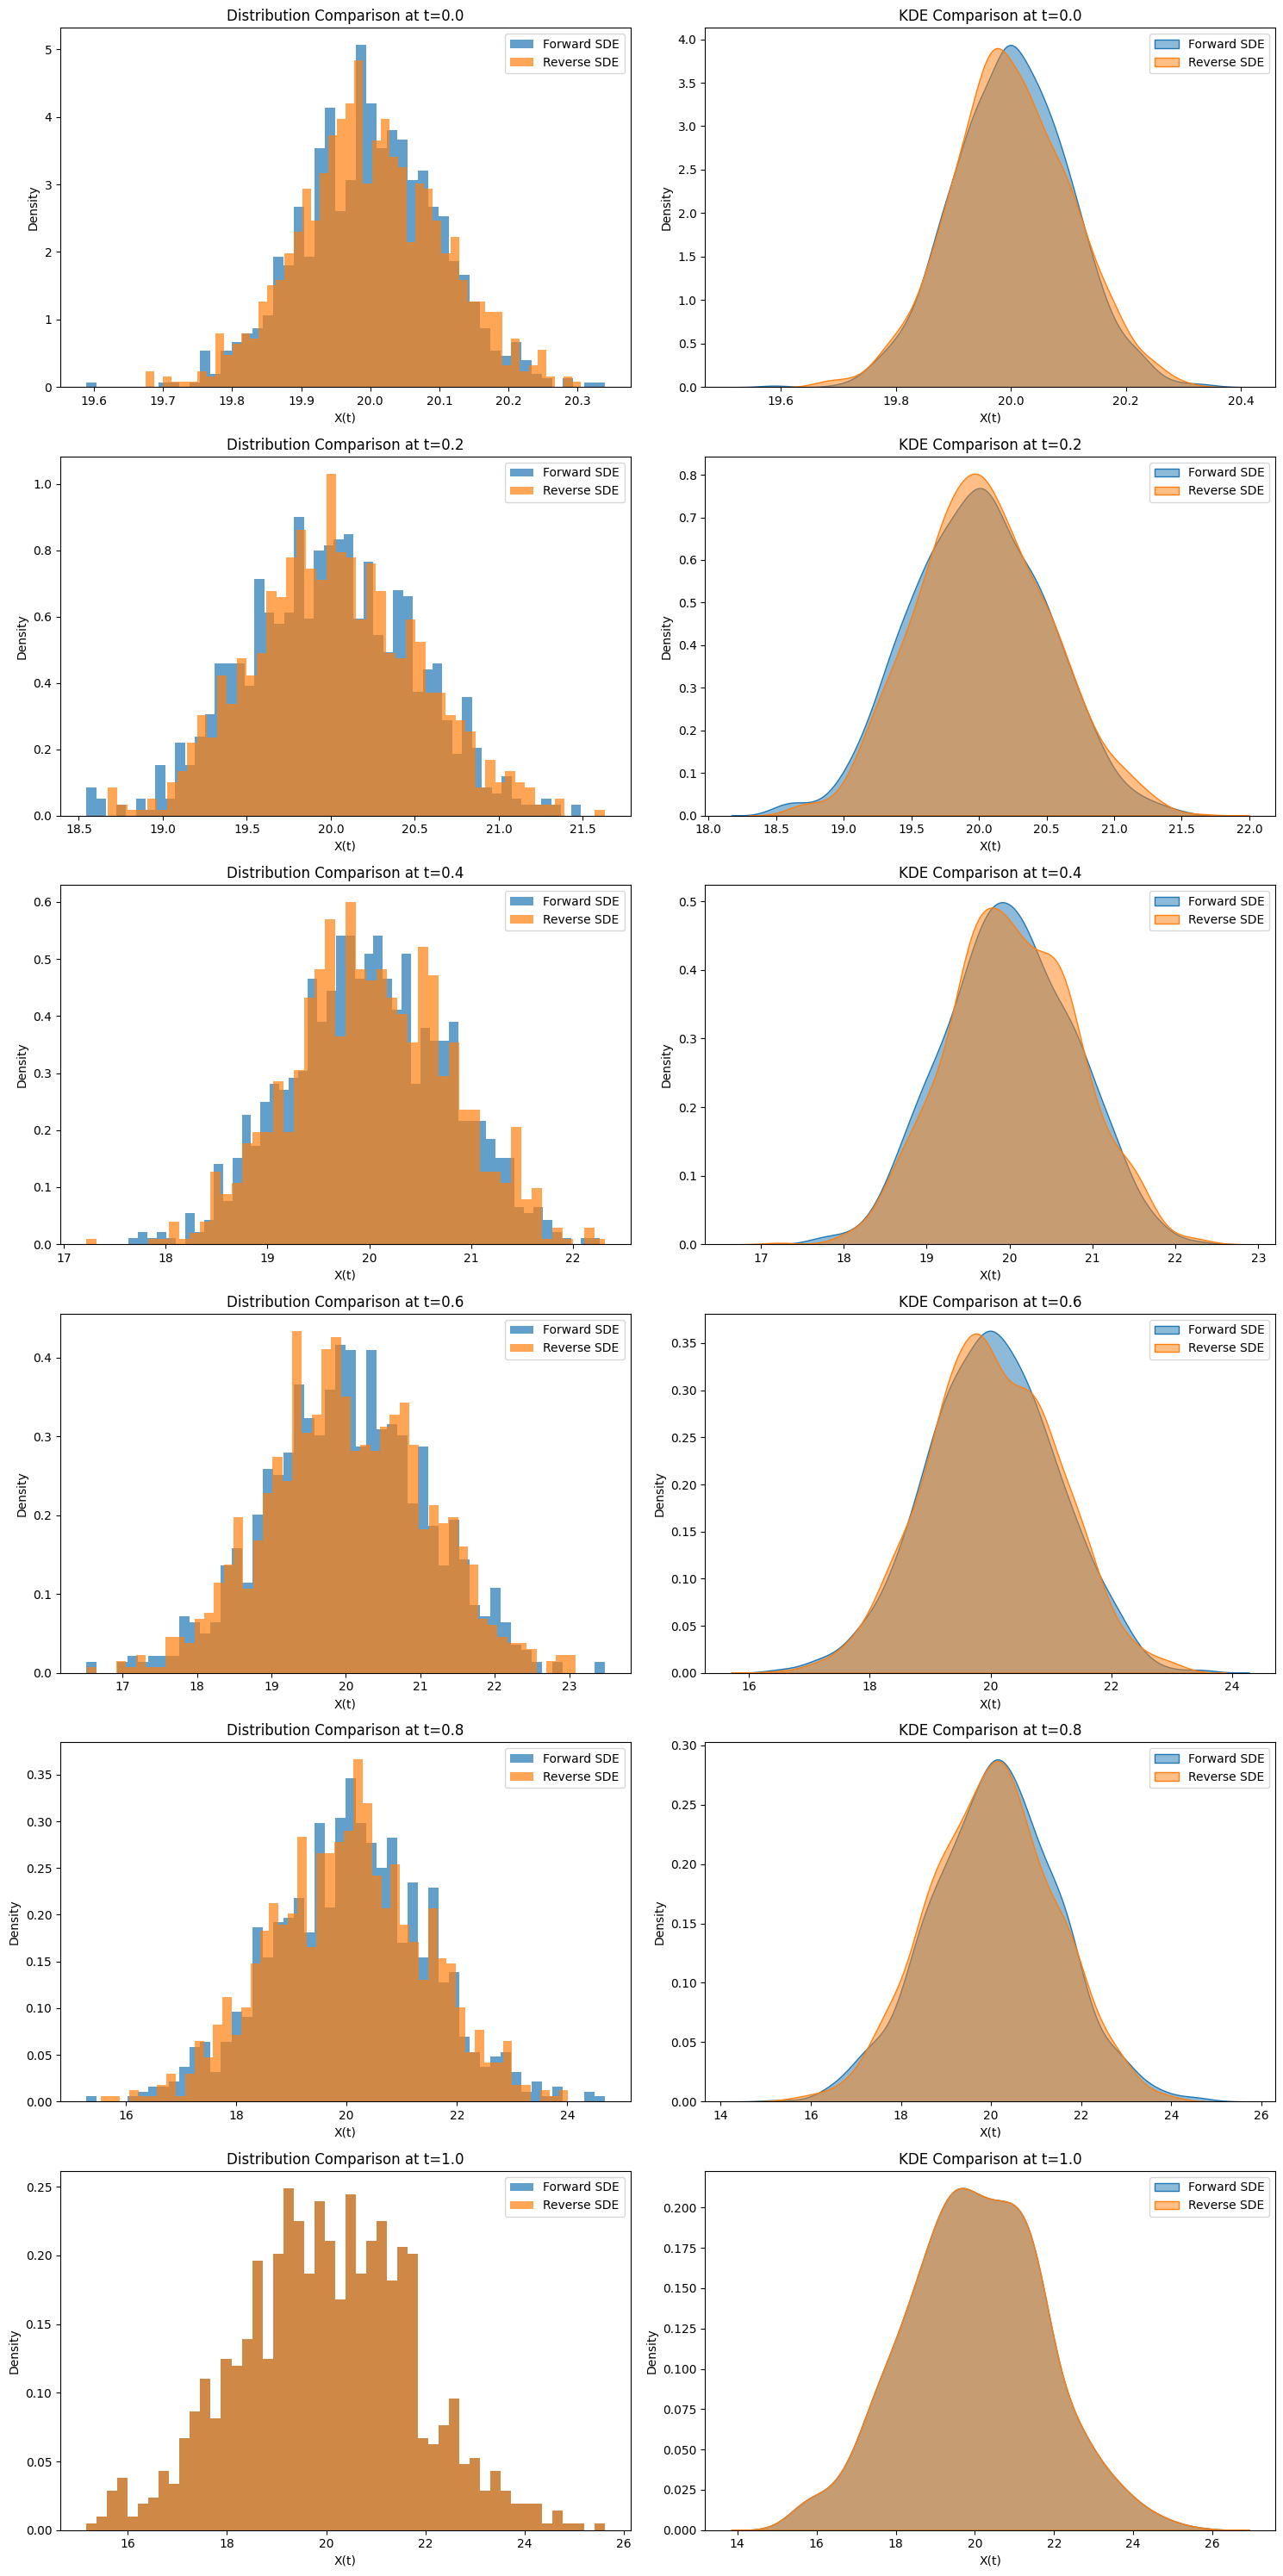

In [24]:
import seaborn as sns

# Times to compare
compare_times = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
compare_indices = [np.argmin(np.abs(sde.t - t)) for t in compare_times]

print(compare_indices)

plt.figure(figsize=(15, len(compare_times) * 5))

for idx, t_idx in enumerate(compare_indices):
    t = sde.t[t_idx]
    
    # Forward and reverse values at time t
    forward_values = f_trajectories[:, t_idx, 0]
    reverse_values = r_trajectories[:, -(t_idx + 1), 0]
    
    # Histogram Comparison
    plt.subplot(len(compare_times), 2, 2 * idx + 1)
    plt.hist(forward_values, bins=50, alpha=0.7, label='Forward SDE', density=True)
    plt.hist(reverse_values, bins=50, alpha=0.7, label='Reverse SDE', density=True)
    plt.title(f'Distribution Comparison at t={round(t, 2)}')
    plt.xlabel('X(t)')
    plt.ylabel('Density')
    plt.legend()

    # KDE Comparison
    plt.subplot(len(compare_times), 2, 2 * idx + 2)
    sns.kdeplot(forward_values, label='Forward SDE', fill=True, alpha=0.5)
    sns.kdeplot(reverse_values, label='Reverse SDE', fill=True, alpha=0.5)
    plt.title(f'KDE Comparison at t={round(t, 2)}')
    plt.xlabel('X(t)')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

Now let's try sampling from a mixture of gaussians 

In [ ]:
from sklearn.mixture import GaussianMixture

np.random.seed(42)

# peak 1
mu1 = [2, 2]
sigma1 = [[0.5, 0], [0, 0.5]]

# peak 2
mu2 = [6, 6]
sigma2 = [[1, 0], [0, 1]]

# Mixing weights
weights = [0.4, 0.6]

# Generate samples for each component
n_samples = 1000
n1 = int(weights[0] * n_samples)
n2 = int(weights[1] * n_samples)

print(n1)

samples1 = np.random.multivariate_normal(mu1, sigma1, n1)
samples2 = np.random.multivariate_normal(mu2, sigma2, n2)

# Combine samples
samples = np.vstack([samples1, samples2])


plt.figure(figsize=(8, 6))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=10)
plt.title("Gaussian Mixture Distribution")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid()
plt.show()


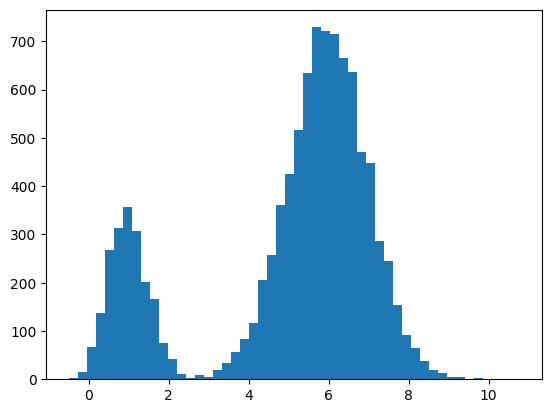

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def sample_gmm(n, weights, means, sds):
   
   # sample component indices 
    components = np.random.choice(len(weights), size=n, p=weights) 

    sample_mean = np.array(means)[components]
    sample_sds = np.array(sds)[components]

    samples = np.random.normal(sample_mean, sample_sds, size = n)
   
    return samples

# peak 1
mu1 = 1
sigma1 = 0.5    

# peak 2
mu2 = 6
sigma2 = 1

weights = [0.2 , 0.8]


samples = sample_gmm(10000, 
                   weights,
                   means=[mu1, mu2], 
                   sds=[sigma1, sigma2])

#print(samples)  

plt.hist(samples, bins=50)
plt.show()

In [26]:
class SBM(nn.Module):
    def __init__(self, snet, sigma, )